# Розроблення та дослідження нейронної мережі для розпізнавання дорожних знаків

Виконав студент 565ам групи, Скринник Єгор Ігорович.  

Розпочинаємо із імпорту всіх необхідних для навчання нейронних мереж бібліотек:

In [ ]:
!pip install visualkeras

import numpy as np
import pandas as pd
import os
import cv2
import visualkeras
import matplotlib.pyplot as plt
import tensorflow as tf
import random

from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.applications import VGG19
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, AveragePooling2D, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from matplotlib import style
from matplotlib.image import imread
from google.colab import files

np.random.seed(42)
style.use('fivethirtyeight')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 992 kB 27.9 MB/s 


In [ ]:
!pip freeze > requirements.txt

##  Підготовка зображень для навчання нейронної мережі

Завантажуємо зображення для навчання:

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content"
!mkdir TrafficSignRecognitionDataset
%cd TrafficSignRecognitionDataset
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
!unzip \*.zip  && rm *.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: train/5/00005_00053_00010.png  
  inflating: train/5/00005_00053_00011.png  
  inflating: train/5/00005_00053_00012.png  
  inflating: train/5/00005_00053_00013.png  
  inflating: train/5/00005_00053_00014.png  
  inflating: train/5/00005_00053_00015.png  
  inflating: train/5/00005_00053_00016.png  
  inflating: train/5/00005_00053_00017.png  
  inflating: train/5/00005_00053_00018.png  
  inflating: train/5/00005_00053_00019.png  
  inflating: train/5/00005_00053_00020.png  
  inflating: train/5/00005_00053_00021.png  
  inflating: train/5/00005_00053_00022.png  
  inflating: train/5/00005_00053_00023.png  
  inflating: train/5/00005_00053_00024.png  
  inflating: train/5/00005_00053_00025.png  
  inflating: train/5/00005_00053_00026.png  
  inflating: train/5/00005_00053_00027.png  
  inflating: train/5/00005_00053_00028.png  
  inflating: train/5/00005_00053_00029.png  
  inflating: train/5/00005_00054

Задаємо параметри(шлях до набору даних, розміри зображень):

In [ ]:
# Каталог із завантаженними данними
data_dir = os.curdir
# Каталог із данними для навчання
train_path = 'Train'
# Каталог із даннами для тестування
test_path = 'Test'

# Встановлюємо розмір зображення 32х32
image_height = 32
image_width = 32
# Кількість каналів у зображенні: RGB 
channels = 3

Рахуємо кількість класів в вихідному наборі даних:

In [ ]:
classes_amount = len(os.listdir(train_path))
classes_amount

43

Вказуємо назви класів набору даних:


In [ ]:
# Класи зображень у наборі даних
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

Візуалізуємо кількість зображень кожного класу на графіку:

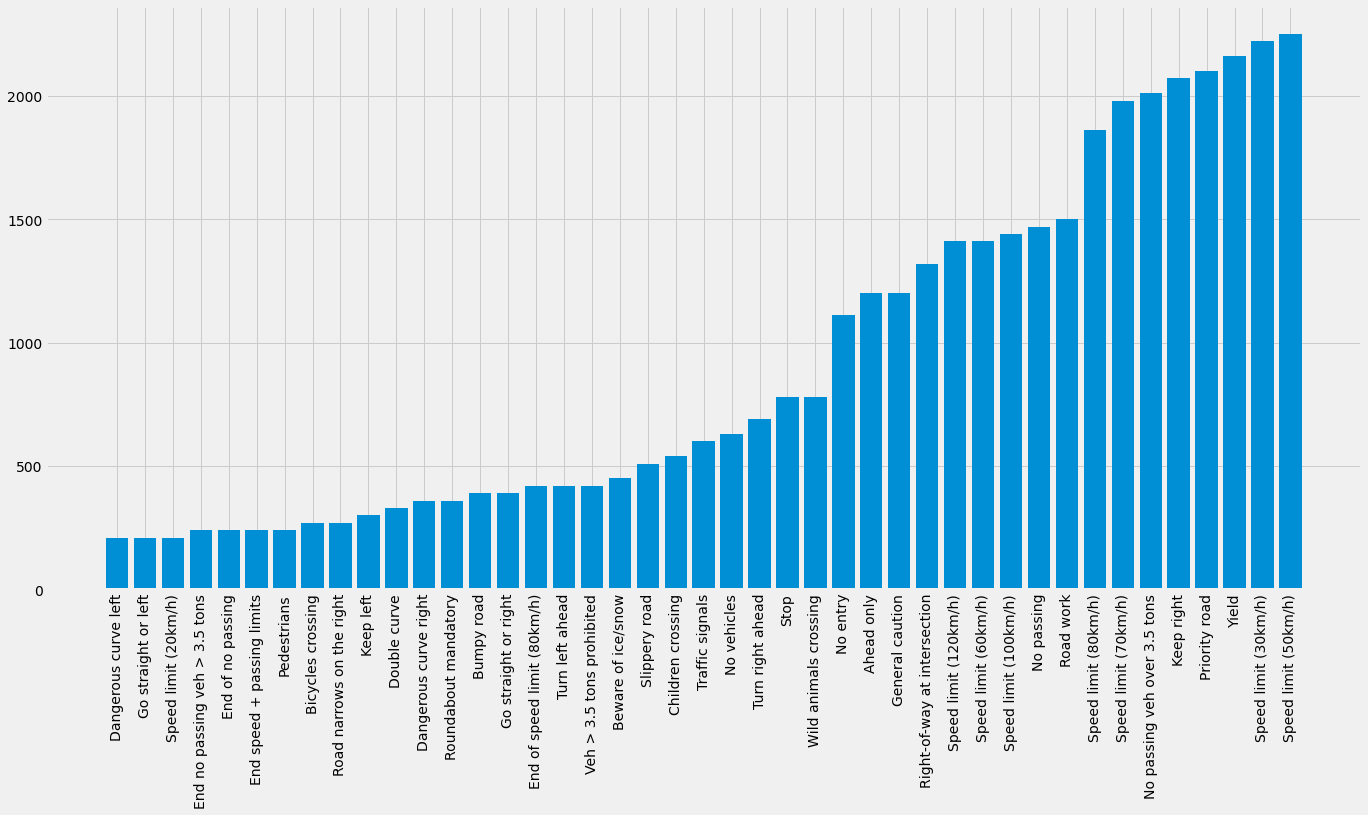

In [ ]:
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])
    
# Сортуємо набір даних за кількістю зображень у кожному класі
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Візуалізація кількості зображень у класах на графіку
plt.figure(figsize=(21,10))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

Візуалізуємо 25 випадкових зображень із набору даних для тестування нейронної мережі:

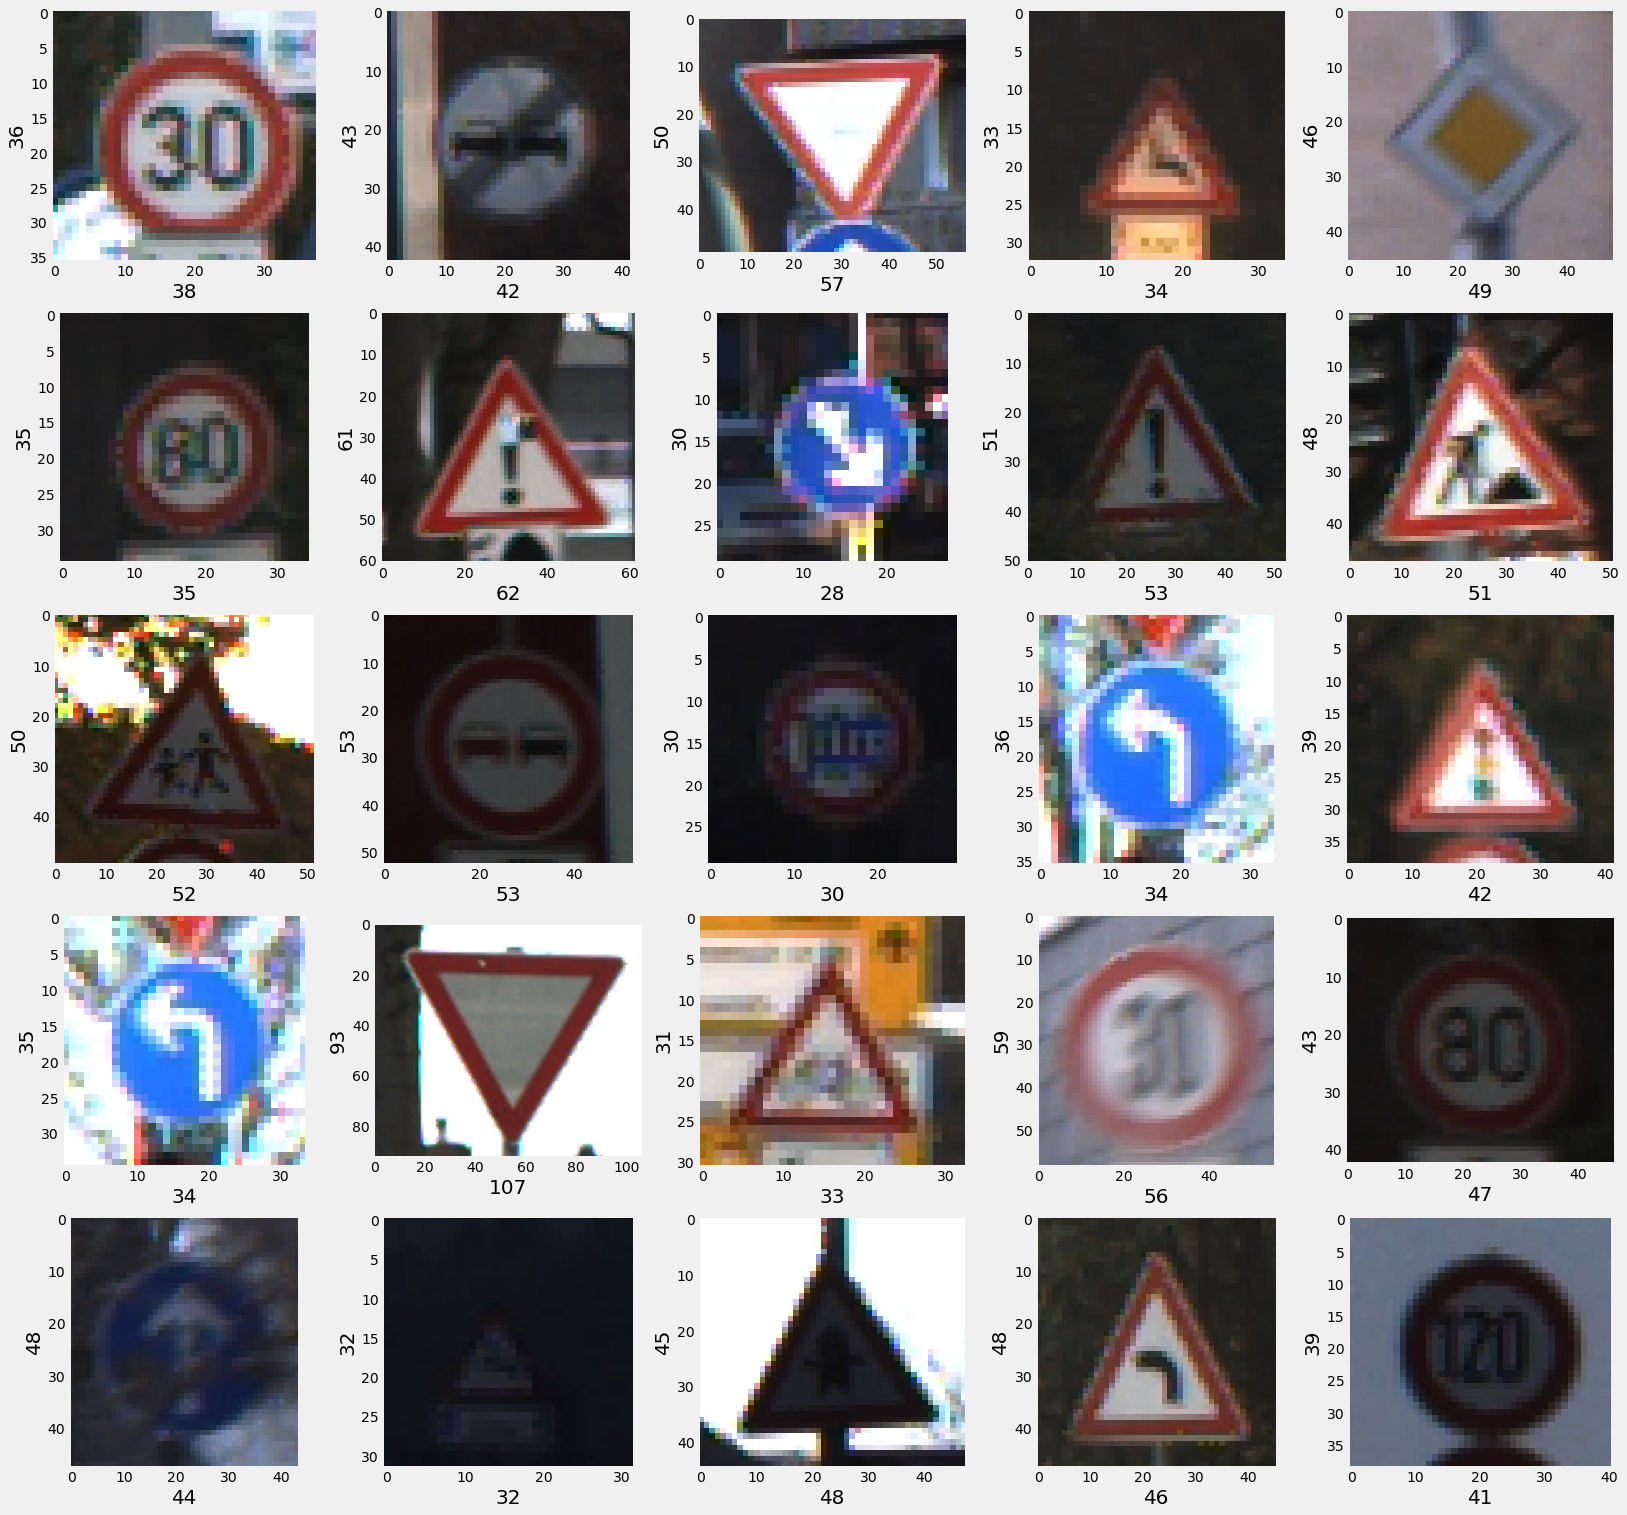

In [ ]:
test = pd.read_csv(data_dir + '/Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path = data_dir + '/' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(b=None)
    plt.xlabel(rand_img.shape[1], fontsize = 20)
    plt.ylabel(rand_img.shape[0], fontsize = 20)

Завантажуємо дані для навчання:

In [ ]:
image_data = []
image_labels = []

for i in range(classes_amount):
    path = data_dir + '/Train/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)[...,::-1]
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((image_height, image_width))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)

# Трансформуємо список у numpy масив
image_data = np.array(image_data)
image_labels = np.array(image_labels)


Перемішаємо дані для навчання:

In [ ]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

Розділимо дані на 2 групи, для навчання та для валідації:

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

Нормалізуємо дані:

In [ ]:
X_train = X_train/255 
X_val = X_val/255

Перетворюємо правильні відповіді у формат one hot encoding:

In [ ]:
y_train = keras.utils.to_categorical(y_train, classes_amount)
y_val = keras.utils.to_categorical(y_val, classes_amount)

Аугментація даних для навчання нейромережі:

In [ ]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

## Створення моделей нейронних мереж.

Загальні налаштування:

In [ ]:
# Кількість епох для навчання
epochs = 30
# Розмір вибірки
batch_size = 32
# Швидкість навчання
learning_rate = 0.001
# Розпад
decay = 0.001 / (epochs * 0.5)

Створюємо модель згорткової нейронної мережі зі тринадцятьма шарами:

In [ ]:
# Створюємо послідовну модель
model = Sequential()
# Перший згортковий шар
model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', 
                              input_shape=(image_height,image_width,channels)))
# Другий згортковий шар
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
# Перший шар підвиборки
model.add(MaxPool2D(pool_size=(2, 2)))
# Шар нормалізації
model.add(BatchNormalization(axis=-1))
# Третій згортковий шар
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
# Четвертий згортковий шар
model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
# Другий шар підвиборки
model.add(MaxPool2D(pool_size=(2, 2)))
# Шар нормалізації
model.add(BatchNormalization(axis=-1))
# Шар перетворення даних з 2D подання в плоске
model.add(Flatten())
# Повнозв'язковий шар для класифікації
model.add(Dense(512, activation='relu'))
# Шар нормалізації 
model.add(BatchNormalization())
# Шар регуляризації Dropout
model.add(Dropout(0.5))
# Вихідний повнозв'язковий шар
model.add(Dense(classes_amount, activation='softmax'))

Виводимо інформацію про створену мережу:

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 128)       7

Компілюємо модель:

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate, decay=decay), metrics=['accuracy'])

Візуалізуємо модель:

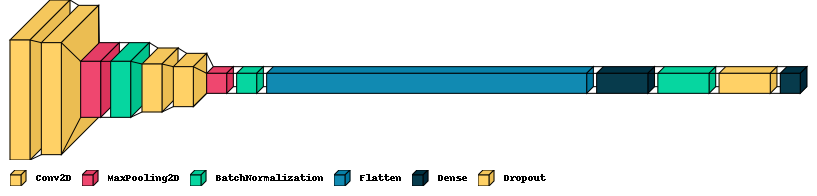

In [ ]:
visualkeras.layered_view(model, legend=True)

Створюємо модель згорткової нейронної мережі із використанням готової архітектури нейронної мережі VGG19:

In [ ]:
# Створюємо послідовну модель
modelVGG19 = Sequential()
# Додаємо VGG19 до архітектури
modelVGG19.add(VGG19(weights='imagenet', include_top=False, input_shape=(image_height, image_width,   channels)))
# Шар нормалізації
modelVGG19.add(BatchNormalization())
# Шар перетворення даних з 2D подання в плоске
modelVGG19.add(Flatten())
# Повнозв'язковий шар для класифікації
modelVGG19.add(Dense(1024, activation='sigmoid'))
# Вихідний повнозв'язковий шар
modelVGG19.add(Dense(classes_amount, activation='softmax'))

80134624/80134624 [==============================] - 4s 0us/step


Виводимо інформацію про створену мережу:

In [ ]:
print(modelVGG19.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 batch_normalization_3 (Batc  (None, 1, 1, 512)        2048      
 hNormalization)                                                 
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 1024)              525312    
                                                                 
 dense_3 (Dense)             (None, 43)                44075     
                                                                 
Total params: 20,595,819
Trainable params: 20,594,795
Non-trainable params: 1,024
______________________________________

Компілюємо модель:

In [ ]:
modelVGG19.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate, decay=decay), metrics=['accuracy'])

Візуалізуємо модель:

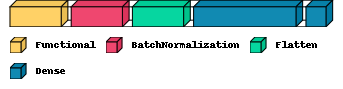

In [ ]:
visualkeras.layered_view(modelVGG19, legend=True)

Створюємо модель згорткової нейронної мережі LeNet-5:

In [ ]:
# Створюємо послідовну модель
modelLN5 = Sequential()

# Перший згортковий шар
modelLN5.add(Conv2D(filters=6, kernel_size=(5,5), strides=1, activation='tanh', input_shape=(image_height, image_width, channels)))
# Перший шар усердненого пулінгу
modelLN5.add(AveragePooling2D(pool_size=(2,2), strides=2))
# Другий згортковий шар
modelLN5.add(Conv2D(filters=16, kernel_size=(5,5), strides=1, activation='tanh'))
# Другий шар усередненого пулінгу
modelLN5.add(AveragePooling2D(pool_size=(2,2), strides=2))
# Третій згортковий шар
modelLN5.add(Conv2D(filters=120, kernel_size=(5, 5), activation='tanh'))
# Шар перетворення даних з 2D подання в плоске
modelLN5.add(Flatten())
# Повнозв'язковий шар для класифікації
modelLN5.add(Dense(units=84, activation='tanh'))
# Вихідний повнозв'язковий шар
modelLN5.add(Dense(units=classes_amount, activation='softmax'))

Візуалізуємо модель:

In [ ]:
print(modelLN5.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 6)         456       
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_5 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 5, 5, 16)         0         
 ePooling2D)                                                     
                                                                 
 conv2d_6 (Conv2D)           (None, 1, 1, 120)         48120     
                                                                 
 flatten_2 (Flatten)         (None, 120)              

Компілюємо модель:

In [ ]:
modelLN5.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate, decay=decay), metrics=['accuracy'])

Візуалізуємо модель:

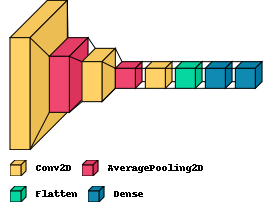

In [ ]:
visualkeras.layered_view(modelLN5, legend=True)

## Навчаємо нейронну мережу

Навчаємо модель згорткової нейронної мережі зі тринадцятьма шарами:

In [ ]:
history = model.fit(aug.flow(X_train, y_train, batch_size=batch_size), epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/30
858/858 [==============================] - 32s 26ms/step - loss: 1.1133 - accuracy: 0.6985 - val_loss: 0.0789 - val_accuracy: 0.9787
Epoch 2/30
858/858 [==============================] - 21s 25ms/step - loss: 0.1864 - accuracy: 0.9426 - val_loss: 0.0303 - val_accuracy: 0.9910
Epoch 3/30
858/858 [==============================] - 18s 21ms/step - loss: 0.0982 - accuracy: 0.9706 - val_loss: 0.0209 - val_accuracy: 0.9934
Epoch 4/30
858/858 [==============================] - 18s 21ms/step - loss: 0.0815 - accuracy: 0.9761 - val_loss: 0.0139 - val_accuracy: 0.9957
Epoch 5/30
858/858 [==============================] - 19s 22ms/step - loss: 0.0667 - accuracy: 0.9788 - val_loss: 0.0102 - val_accuracy: 0.9974
Epoch 6/30
858/858 [==============================] - 18s 21ms/step - loss: 0.0540 - accuracy: 0.9827 - val_loss: 0.0139 - val_accuracy: 0.9970
Epoch 7/30
858/858 [==============================] - 18s 21ms/step - loss: 0.0491 - accuracy: 0.9842 - val_loss: 0.0233 - val_accuracy:

Навчаємо модель із VGG19:

In [ ]:
historyVGG19 = modelVGG19.fit(aug.flow(X_train, y_train, batch_size=batch_size), epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/30
858/858 [==============================] - 38s 42ms/step - loss: 2.7979 - accuracy: 0.1628 - val_loss: 2.4240 - val_accuracy: 0.1873
Epoch 2/30
858/858 [==============================] - 34s 40ms/step - loss: 2.3807 - accuracy: 0.2202 - val_loss: 3.0942 - val_accuracy: 0.1000
Epoch 3/30
858/858 [==============================] - 34s 40ms/step - loss: 1.7403 - accuracy: 0.4071 - val_loss: 1.1058 - val_accuracy: 0.6173
Epoch 4/30
858/858 [==============================] - 34s 40ms/step - loss: 1.1272 - accuracy: 0.6026 - val_loss: 0.7604 - val_accuracy: 0.7449
Epoch 5/30
858/858 [==============================] - 35s 41ms/step - loss: 0.8236 - accuracy: 0.7094 - val_loss: 0.5015 - val_accuracy: 0.8217
Epoch 6/30
858/858 [==============================] - 34s 40ms/step - loss: 0.6386 - accuracy: 0.7759 - val_loss: 0.5103 - val_accuracy: 0.8247
Epoch 7/30
858/858 [==============================] - 34s 40ms/step - loss: 0.4908 - accuracy: 0.8307 - val_loss: 0.2643 - val_accuracy:

Навчаємо модель із LeNet-5:

In [ ]:
historyLN5 = modelLN5.fit(aug.flow(X_train, y_train, batch_size=batch_size), epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/30
858/858 [==============================] - 17s 19ms/step - loss: 2.1015 - accuracy: 0.3868 - val_loss: 1.1365 - val_accuracy: 0.6524
Epoch 2/30
858/858 [==============================] - 16s 19ms/step - loss: 1.3417 - accuracy: 0.5945 - val_loss: 0.7521 - val_accuracy: 0.7847
Epoch 3/30
858/858 [==============================] - 16s 18ms/step - loss: 1.0038 - accuracy: 0.7000 - val_loss: 0.5204 - val_accuracy: 0.8649
Epoch 4/30
858/858 [==============================] - 16s 18ms/step - loss: 0.7867 - accuracy: 0.7649 - val_loss: 0.4061 - val_accuracy: 0.8899
Epoch 5/30
858/858 [==============================] - 18s 21ms/step - loss: 0.6563 - accuracy: 0.8041 - val_loss: 0.3532 - val_accuracy: 0.8957
Epoch 6/30
858/858 [==============================] - 16s 18ms/step - loss: 0.5534 - accuracy: 0.8366 - val_loss: 0.2673 - val_accuracy: 0.9311
Epoch 7/30
858/858 [==============================] - 16s 19ms/step - loss: 0.4741 - accuracy: 0.8600 - val_loss: 0.2247 - val_accuracy:

## Зберігаємо нейронні мережі для подальшого використання

Зберігаємо нейронну мережу із тринадцятьма шарами:

In [ ]:
model.save('TrafficSignRecognitionCNN_13')

!zip -r /content/TrafficSignRecognitionCNN_13.zip /content/TrafficSignRecognitionDataset/TrafficSignRecognitionCNN_13

files.download("/content/TrafficSignRecognitionCNN_13.zip")

KeyboardInterrupt: ignored

Зберігаємо нейронну мережу із VGG19:

In [ ]:
modelVGG19.save('TrafficSignRecognitionCNN_VGG19')

!zip -r /content/TrafficSignRecognitionCNN_VGG19.zip /content/TrafficSignRecognitionDataset/TrafficSignRecognitionCNN_VGG19

files.download("/content/TrafficSignRecognitionCNN_VGG19.zip")

Зберігаємо нейронну мережу із LeNet-5:

In [ ]:
modelLN5.save('TrafficSignRecognitionCNN_LN5')

!zip -r /content/TrafficSignRecognitionCNN_LN5.zip /content/TrafficSignRecognitionDataset/TrafficSignRecognitionCNN_LN5

files.download("/content/TrafficSignRecognitionCNN_LN5.zip")

  adding: content/TrafficSignRecognitionDataset/TrafficSignRecognitionCNN_LN5/ (stored 0%)
  adding: content/TrafficSignRecognitionDataset/TrafficSignRecognitionCNN_LN5/assets/ (stored 0%)
  adding: content/TrafficSignRecognitionDataset/TrafficSignRecognitionCNN_LN5/variables/ (stored 0%)
  adding: content/TrafficSignRecognitionDataset/TrafficSignRecognitionCNN_LN5/variables/variables.index (deflated 66%)
  adding: content/TrafficSignRecognitionDataset/TrafficSignRecognitionCNN_LN5/variables/variables.data-00000-of-00001 (deflated 9%)
  adding: content/TrafficSignRecognitionDataset/TrafficSignRecognitionCNN_LN5/keras_metadata.pb (deflated 91%)
  adding: content/TrafficSignRecognitionDataset/TrafficSignRecognitionCNN_LN5/saved_model.pb (deflated 88%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Оцінюємо якість навчання нейронних мереж

 Нейронна мережа із тринадцятьма шарами:

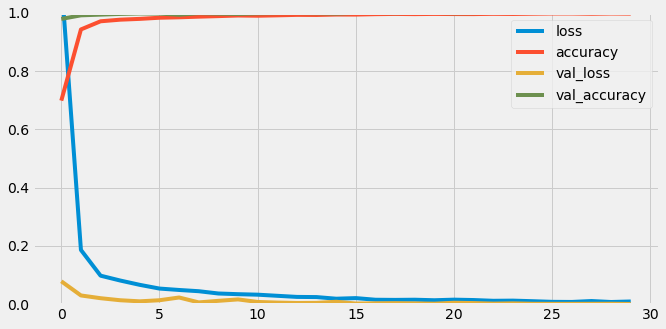

In [ ]:
pd.DataFrame(history.history).plot(figsize=(10, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

Нейронна мережа із VGG19:

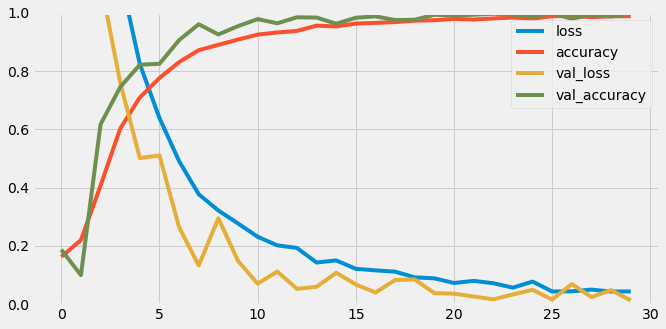

In [ ]:
pd.DataFrame(historyVGG19.history).plot(figsize=(10, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

Нейронна мережа із LeNet-5:

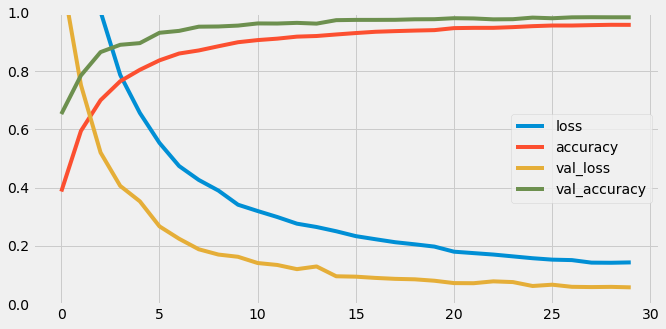

In [ ]:
pd.DataFrame(historyLN5.history).plot(figsize=(10, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

Завантаження зображень для тестування:

In [ ]:
test = pd.read_csv(data_dir + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

Функції для створення зображень із перешкодами

In [ ]:
def resizeAndTransformImageToNumpyArray(image):
  image_fromarray = Image.fromarray(image, 'RGB')
  resized_image = image_fromarray.resize((image_height, image_width))

  return np.array(resized_image)

def createBlurImage(image):
  blur_img = cv2.blur(image,(5,5))

  return resizeAndTransformImageToNumpyArray(blur_img)

def createGaussianBlurImage(image):
  gaussian_blur_img = cv2.GaussianBlur(image, (5,5), 0)

  return resizeAndTransformImageToNumpyArray(gaussian_blur_img)

def createGaussianNoiseImage(image):
  
  gaussian_noise = np.zeros((image.shape), dtype = np.uint8)
  cv2.randn(gaussian_noise, 128, 20)
  gaussian_noise = (gaussian_noise * 0.5).astype(np.uint8)
  gaussian_noise_img = cv2.add(image, gaussian_noise)

  return resizeAndTransformImageToNumpyArray(gaussian_noise_img)

def createUniformNoiseImage(image):
  uniform_noise = np.zeros((image.shape), dtype = np.uint8)
  cv2.randu(uniform_noise, 0, 255)
  uniform_noise = (uniform_noise* 0.5).astype(np.uint8)
  uniform_noise_img = cv2.add(image, uniform_noise)

  return resizeAndTransformImageToNumpyArray(uniform_noise_img)


def createImpulseNoiseImage(image):
  impulse_noise = np.zeros((image.shape), dtype = np.uint8)
  cv2.randu(impulse_noise, 0, 255)
  impulse_noise = cv2.threshold(impulse_noise, 245, 255, cv2.THRESH_BINARY)[1]
  impulse_noise_img = cv2.add(image, impulse_noise)

  return resizeAndTransformImageToNumpyArray(impulse_noise_img)

Завантаження набору данних для тестування

In [ ]:
data =[]
data_blur =[]
data_gaussian_blur =[]
data_gaussian_noise =[]
data_uniform_noise =[]
data_impulse_noise =[]

for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' +img)[...,::-1]

        data.append(resizeAndTransformImageToNumpyArray(image))
        data_blur.append(createBlurImage(image))
        data_gaussian_blur.append(createGaussianBlurImage(image))
        data_gaussian_noise.append(createGaussianNoiseImage(image))
        data_uniform_noise.append(createUniformNoiseImage(image))
        data_impulse_noise.append(createImpulseNoiseImage(image))

    except:
        print("Error in " + img)

X_test = np.array(data)
X_blur_test = np.array(data_blur)
X_gaussian_blur_test = np.array(data_gaussian_blur)
X_gaussian_noise_test = np.array(data_gaussian_noise)
X_uniform_noise_test = np.array(data_uniform_noise)
X_impulse_noise_test = np.array(data_impulse_noise)

# Нормалізація тестових даних
X_test = X_test / 255
X_blur_test = X_blur_test / 255
X_gaussian_blur_test = X_gaussian_blur_test / 255
X_gaussian_noise_test = X_gaussian_noise_test / 255
X_uniform_noise_test = X_uniform_noise_test / 255
X_impulse_noise_test = X_impulse_noise_test / 255

Функція для перевірки роботи нейронної мережі із різними наборами тестових даних:

In [ ]:
def getTestDataPrediction(model, testData, testName):
  pred = pred = np.argmax(model.predict(testData), axis=-1)
  print(f'[{testName}] Частка вірних відповідей на тестових даних, у відсотках: {accuracy_score(labels, pred)*100}')
  return pred

Перевіряємо якість роботи нейронної мережі із тринадцятьма шарами:

In [ ]:
# Стандартні зображення:
pred = getTestDataPrediction(model, X_test, "Default")
# Зображення із розмиванням:
pred_blur = getTestDataPrediction(model, X_blur_test, "Blur")
# Зображення із гаусовим розмиванням:
pred_gaussian_blur = getTestDataPrediction(model, X_gaussian_blur_test, "Gaussian blur")
# Зображення із гаусовим шумом:
pred_gaussian_noise = getTestDataPrediction(model, X_gaussian_noise_test, "Gaussian noise")
# Зображення із рівномірним шумом:
pred_uniform_noise = getTestDataPrediction(model, X_uniform_noise_test, "Uniform noise")
# Зображення із імпульсним шумом:
pred_impulse_noise = getTestDataPrediction(model, X_impulse_noise_test, "Impulse noise")

395/395 [==============================] - 1s 2ms/step
[Default] Частка вірних відповідей на тестових даних, у відсотках: 98.33729216152018
395/395 [==============================] - 1s 2ms/step
[Blur] Частка вірних відповідей на тестових даних, у відсотках: 83.72129849564529
395/395 [==============================] - 1s 2ms/step
[Gaussian blur] Частка вірних відповідей на тестових даних, у відсотках: 96.270783847981
395/395 [==============================] - 1s 2ms/step
[Gaussian noise] Частка вірних відповідей на тестових даних, у відсотках: 67.11797307996832
395/395 [==============================] - 1s 2ms/step
[Uniform noise] Частка вірних відповідей на тестових даних, у відсотках: 62.62074425969912
395/395 [==============================] - 1s 2ms/step
[Impulse noise] Частка вірних відповідей на тестових даних, у відсотках: 91.0134600158353


Перевіряємо якість роботи нейронної мережі із VGG19:

In [ ]:
# Стандартні зображення:
predVGG19 = getTestDataPrediction(modelVGG19, X_test, "Default")
# Зображення із розмиванням:
predVGG19_blur = getTestDataPrediction(modelVGG19, X_blur_test, "Blur")
# Зображення із гаусовим розмиванням:
predVGG19_gaussian_blur = getTestDataPrediction(modelVGG19, X_gaussian_blur_test, "Gaussian blur")
# Зображення із гаусовим шумом:
predVGG19_gaussian_noise = getTestDataPrediction(modelVGG19, X_gaussian_noise_test, "Gaussian noise")
# Зображення із рівномірним шумом:
predVGG19_uniform_noise = getTestDataPrediction(modelVGG19, X_uniform_noise_test, "Uniform noise")
# Зображення із імпульсним шумом:
predVGG19_impulse_noise = getTestDataPrediction(modelVGG19, X_impulse_noise_test, "Impulse noise")

395/395 [==============================] - 4s 10ms/step
[Default] Частка вірних відповідей на тестових даних, у відсотках: 96.87252573238322
395/395 [==============================] - 4s 11ms/step
[Blur] Частка вірних відповідей на тестових даних, у відсотках: 80.50673000791765
395/395 [==============================] - 4s 10ms/step
[Gaussian blur] Частка вірних відповідей на тестових даних, у відсотках: 93.68962787015043
395/395 [==============================] - 4s 11ms/step
[Gaussian noise] Частка вірних відповідей на тестових даних, у відсотках: 67.18923198733175
395/395 [==============================] - 4s 11ms/step
[Uniform noise] Частка вірних відповідей на тестових даних, у відсотках: 63.048297703879655
395/395 [==============================] - 4s 9ms/step
[Impulse noise] Частка вірних відповідей на тестових даних, у відсотках: 89.51702296120348


Перевіряємо якість роботи нейронної мережі із архітектурою LeNet-5:

In [ ]:
# Стандартні зображення:
predLN5 = getTestDataPrediction(modelLN5, X_test, "Default")
# Зображення із розмиванням:
predLN5_blur = getTestDataPrediction(modelLN5, X_blur_test, "Blur")
# Зображення із гаусовим розмиванням:
predLN5_gaussian_blur = getTestDataPrediction(modelLN5, X_gaussian_blur_test, "Gaussian blur")
# Зображення із гаусовим шумом:
predLN5_gaussian_noise = getTestDataPrediction(modelLN5, X_gaussian_noise_test, "Gaussian noise")
# Зображення із рівномірним шумом:
predLN5_uniform_noise = getTestDataPrediction(modelLN5, X_uniform_noise_test, "Uniform noise")
# Зображення із імпульсним шумом:
predLN5_impulse_noise = getTestDataPrediction(modelLN5, X_impulse_noise_test, "Impulse noise")

395/395 [==============================] - 1s 2ms/step
[Default] Частка вірних відповідей на тестових даних, у відсотках: 89.04988123515439
395/395 [==============================] - 1s 2ms/step
[Blur] Частка вірних відповідей на тестових даних, у відсотках: 82.55740300870941
395/395 [==============================] - 1s 2ms/step
[Gaussian blur] Частка вірних відповідей на тестових даних, у відсотках: 86.87252573238321
395/395 [==============================] - 1s 2ms/step
[Gaussian noise] Частка вірних відповідей на тестових даних, у відсотках: 34.069675376088675
395/395 [==============================] - 1s 2ms/step
[Uniform noise] Частка вірних відповідей на тестових даних, у відсотках: 34.84560570071259
395/395 [==============================] - 1s 2ms/step
[Impulse noise] Частка вірних відповідей на тестових даних, у відсотках: 77.31591448931117


Функція запуску розпізнавання 25 знаків із тестового набору:

In [ ]:
def launch25(pred, images):
  plt.figure(figsize = (16, 16))
  start_index = random.randint(0,1000)
  for i in range(25):
      plt.subplot(5, 5, i + 1)
      plt.grid(False)
      plt.xticks([])
      plt.yticks([])
      prediction = pred[start_index + i]
      actual = labels[start_index + i]
      col = 'g'
      if prediction != actual:
          col = 'r'
      plt.xlabel('{}'.format(classes[prediction]), color = col)
      plt.imshow(images[start_index + i])
  plt.show()

Розпізнавання 25 знаків із тестового набору з візуалізацією(13):

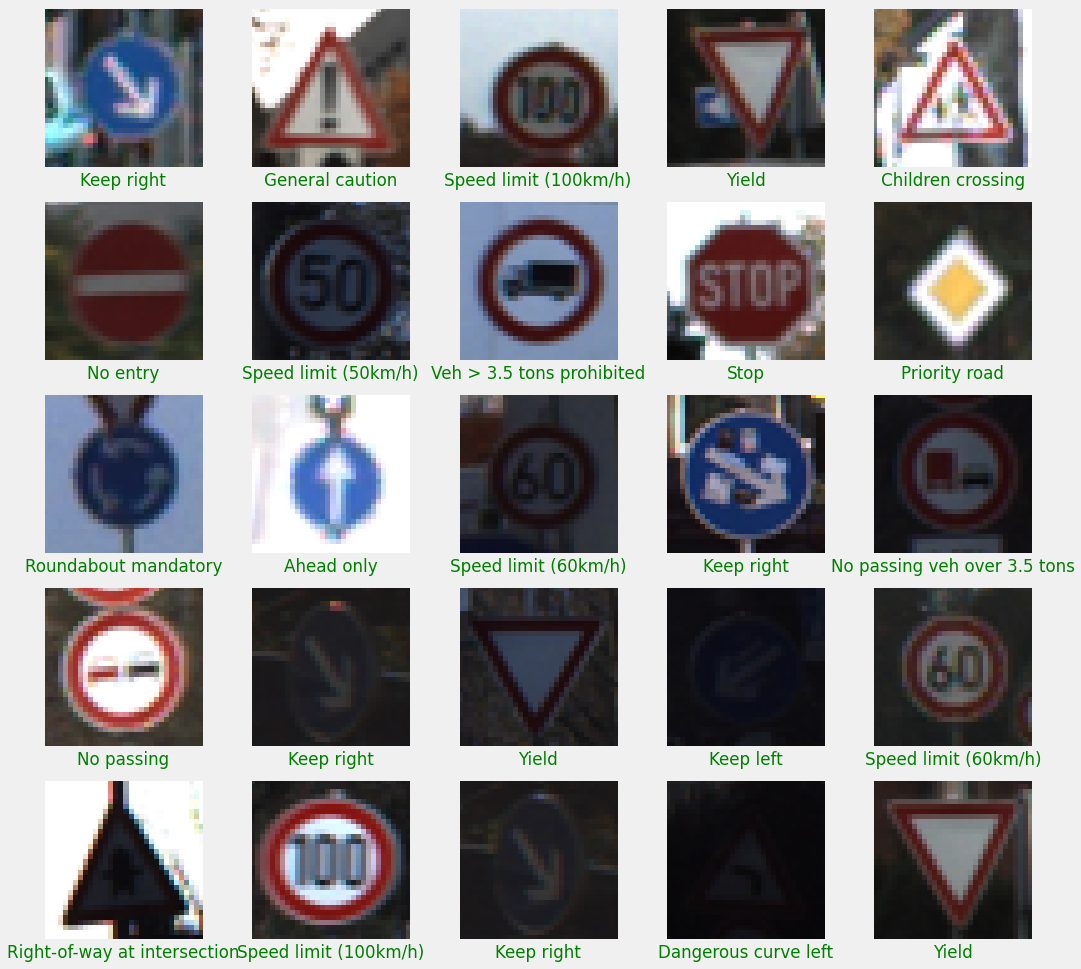

In [ ]:
launch25(pred, X_test)

Розпізнавання 25 знаків із тестового набору з візуалізацією(13) [Blur]:

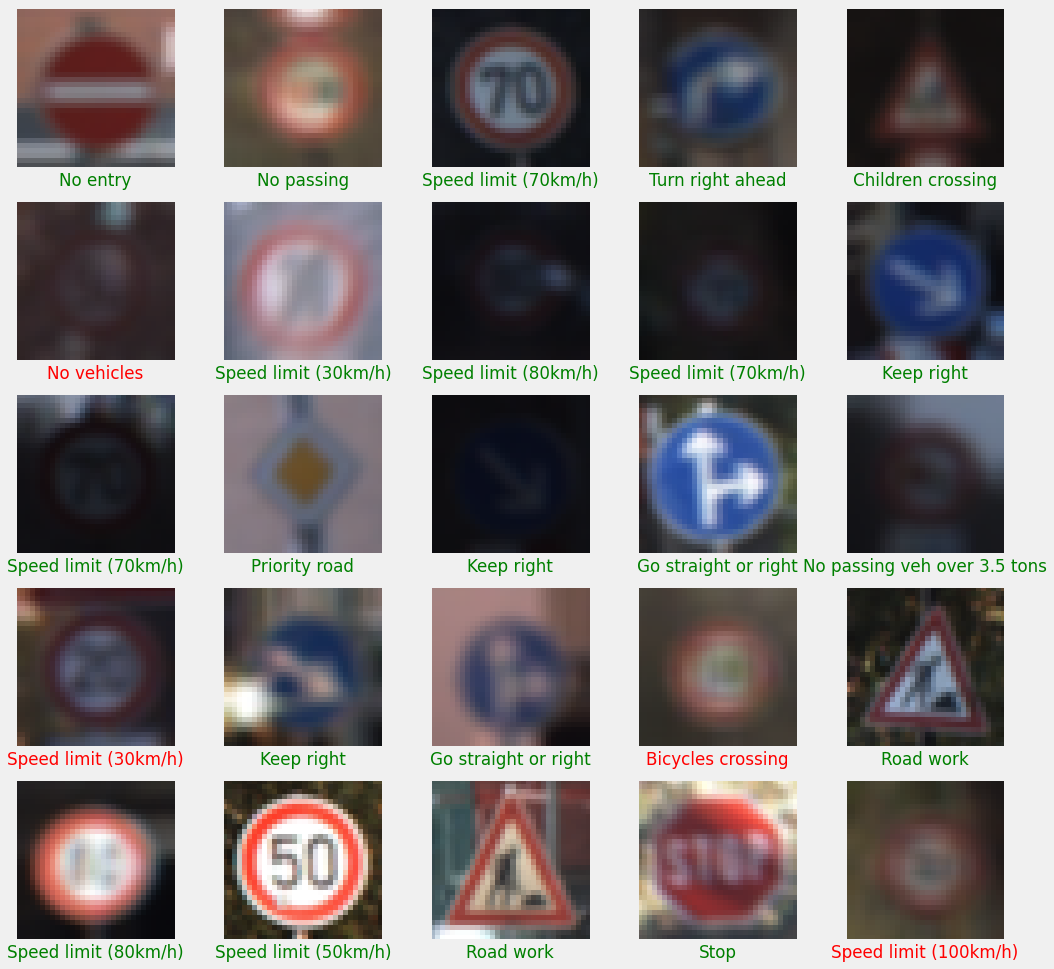

In [ ]:
launch25(pred_blur, X_blur_test)

Розпізнавання 25 знаків із тестового набору з візуалізацією(13) [Gaussian blur]:

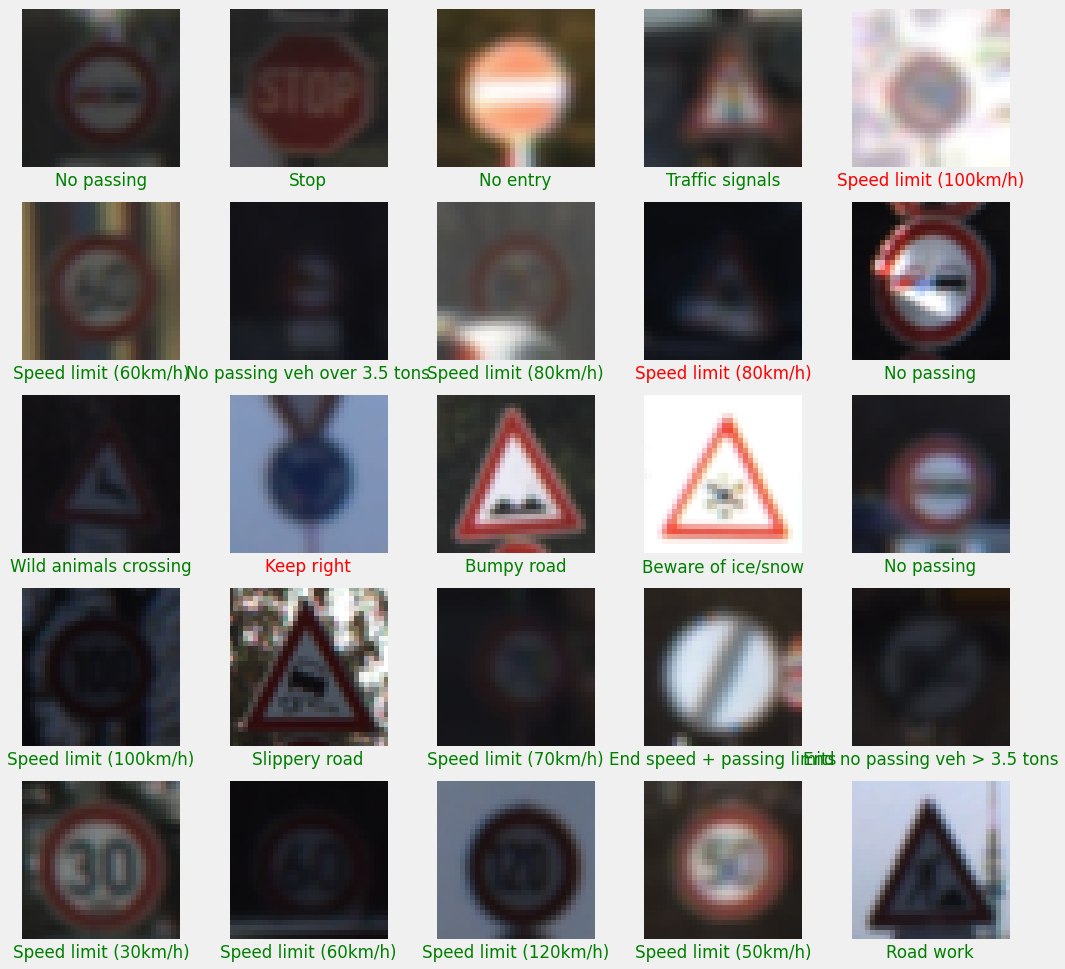

In [ ]:
launch25(pred_gaussian_blur, X_gaussian_blur_test)

Розпізнавання 25 знаків із тестового набору з візуалізацією(13) [Gaussian noise]:

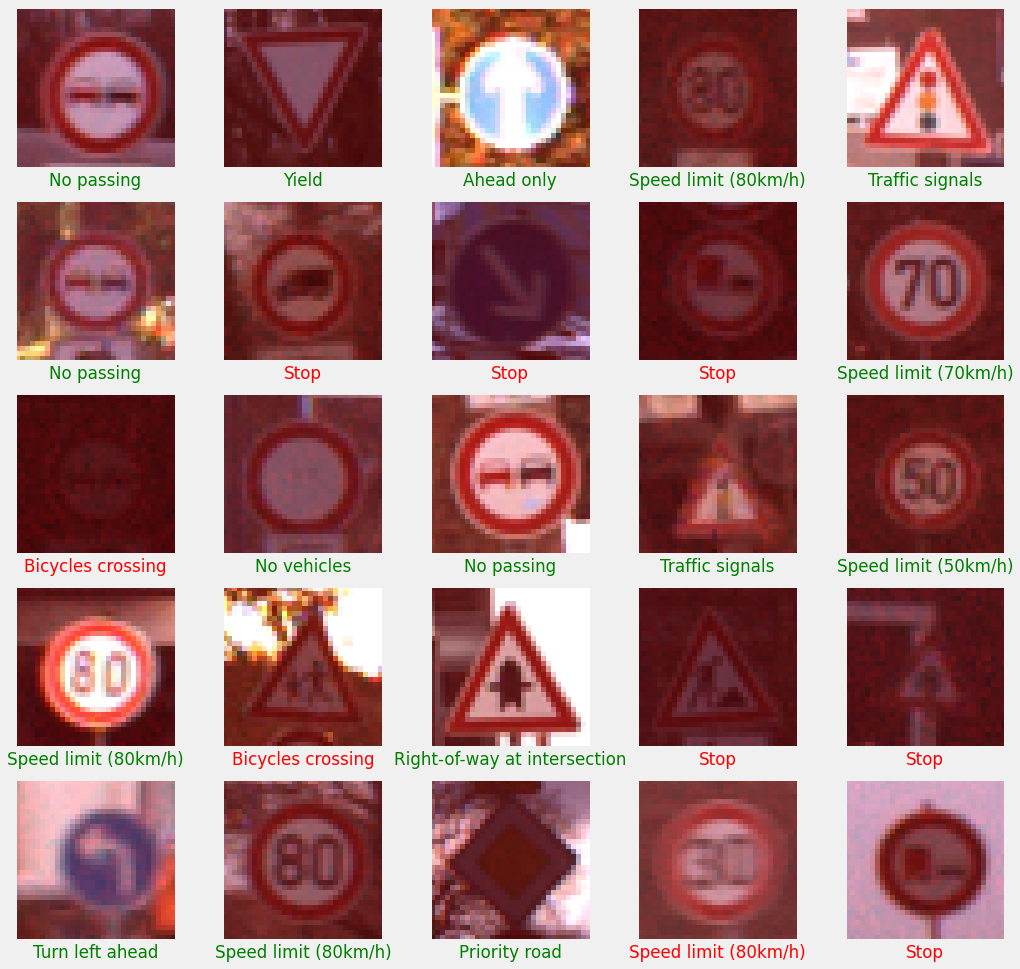

In [ ]:
launch25(pred_gaussian_noise, X_gaussian_noise_test)

Розпізнавання 25 знаків із тестового набору з візуалізацією(13) [Uniform noise]:

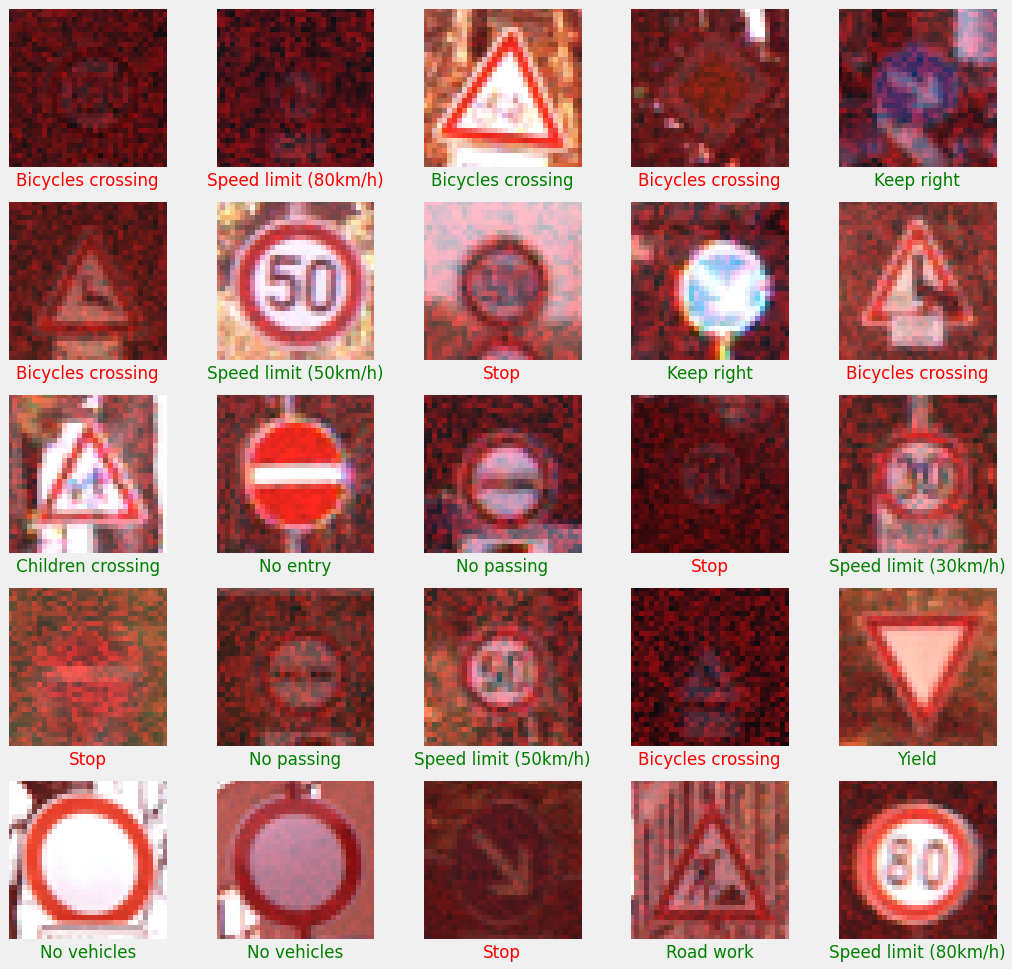

In [ ]:
launch25(pred_uniform_noise, X_uniform_noise_test)

Розпізнавання 25 знаків із тестового набору з візуалізацією(13) [Impulse noise]:

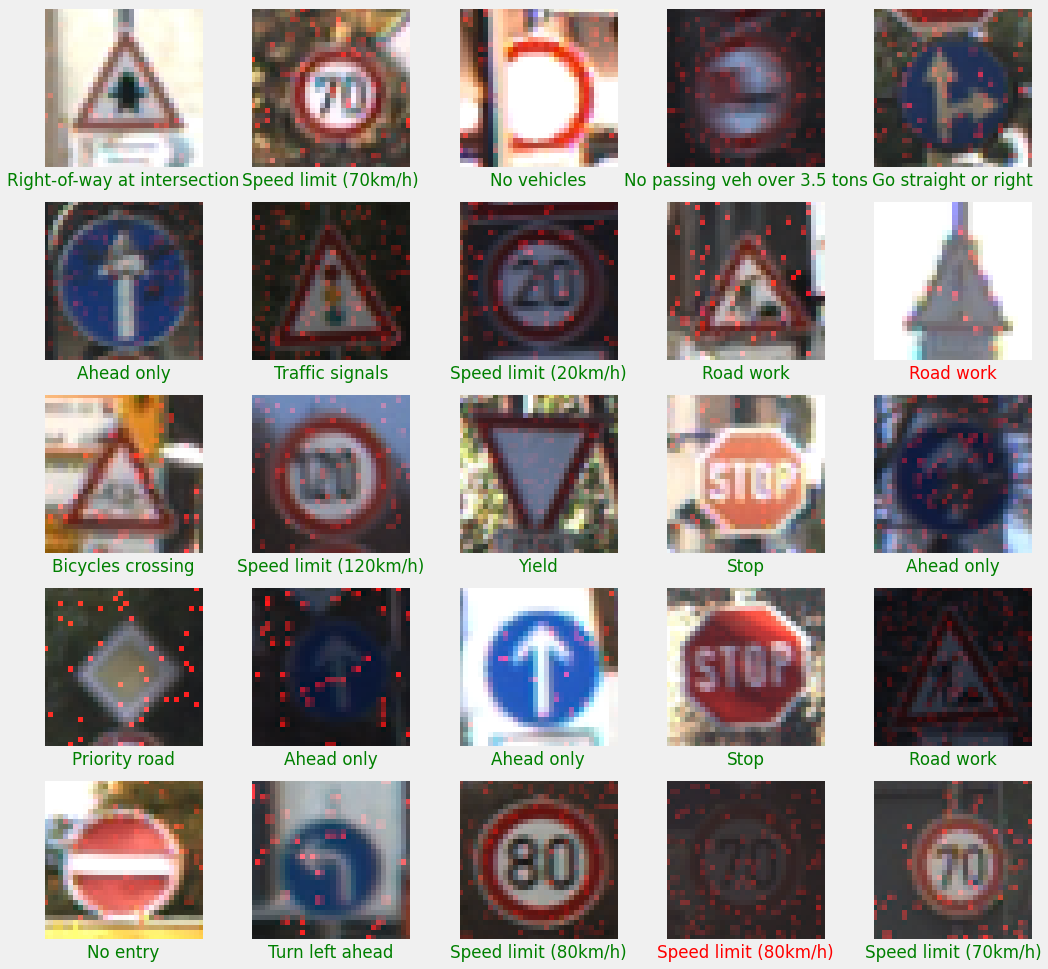

In [ ]:
launch25(pred_impulse_noise, X_impulse_noise_test)

Розпізнавання 25 знаків із тестового набору з візуалізацією(VGG19):

In [ ]:
launch25(predVGG19, X_test)

Розпізнавання 25 знаків із тестового набору з візуалізацією(VGG19) [Blur]:

In [ ]:
launch25(predVGG19_blur, X_blur_test)

Розпізнавання 25 знаків із тестового набору з візуалізацією(VGG19) [Gaussian blur]:

In [ ]:
launch25(predVGG19_gaussian_blur, X_gaussian_blur_test)

Розпізнавання 25 знаків із тестового набору з візуалізацією(VGG19) [Gaussian noise]:

In [ ]:
launch25(predVGG19_gaussian_noise, X_gaussian_noise_test)

Розпізнавання 25 знаків із тестового набору з візуалізацією(VGG19) [Uniform noise]:

In [ ]:
launch25(predVGG19_uniform_noise, X_uniform_noise_test)

Розпізнавання 25 знаків із тестового набору з візуалізацією(VGG19) [Impulse noise]:

In [ ]:
launch25(predVGG19_impulse_noise, X_impulse_noise_test)

Розпізнавання 25 знаків із тестового набору з візуалізацією(LeNet-5):

In [ ]:
launch25(predLN5, X_test)

Розпізнавання 25 знаків із тестового набору з візуалізацією(LeNet-5) [Blur]:

In [ ]:
launch25(predLN5_blur, X_blur_test)

Розпізнавання 25 знаків із тестового набору з візуалізацією(LeNet-5) [Gaussian blur]:

In [ ]:
launch25(predLN5_gaussian_noise, X_gaussian_blur_test)

Розпізнавання 25 знаків із тестового набору з візуалізацією(LeNet-5) [Gaussian noise]:

In [ ]:
launch25(predLN5_gaussian_noise, X_gaussian_noise_test)

Розпізнавання 25 знаків із тестового набору з візуалізацією(LeNet-5) [Uniform noise]:

In [ ]:
launch25(predLN5_uniform_noiuse, X_uniform_noise_test)

Розпізнавання 25 знаків із тестового набору з візуалізацією(LeNet-5) [Impulse noise]:

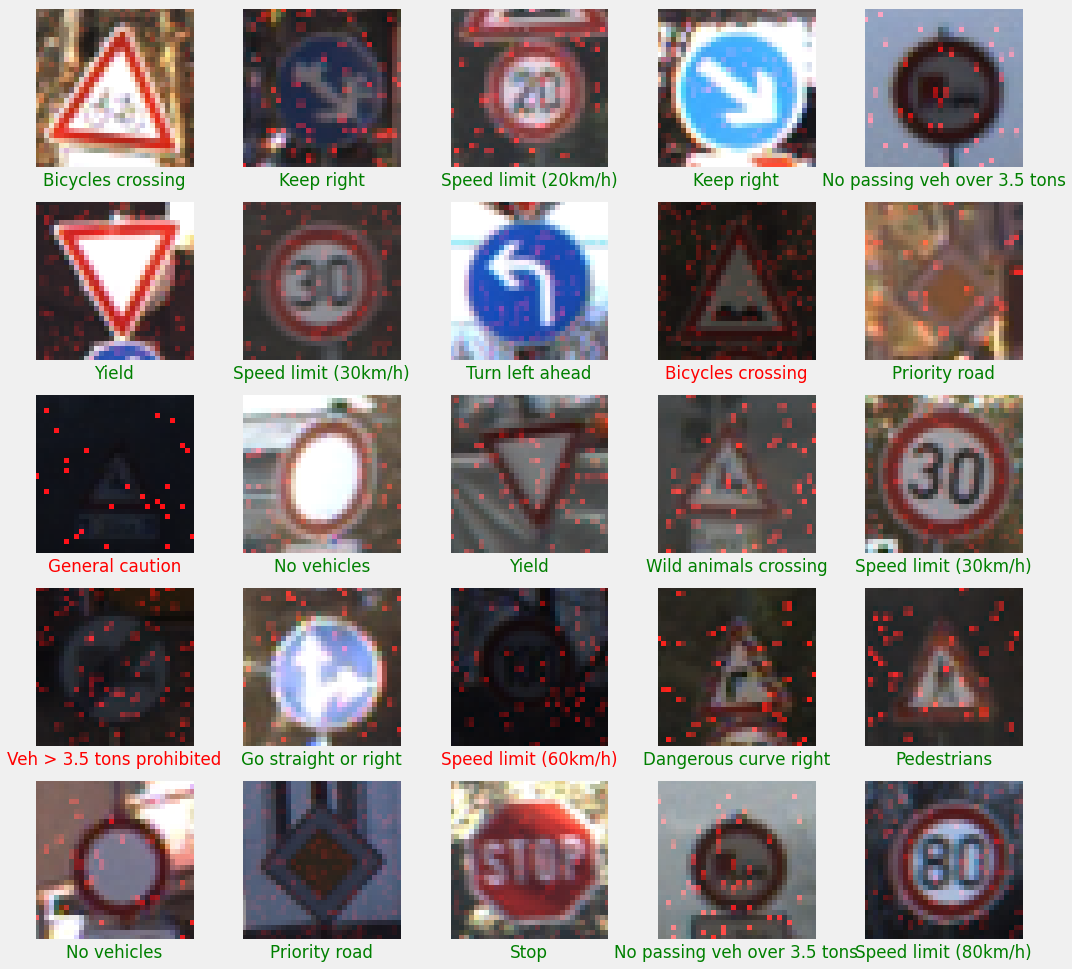

In [ ]:
launch25(predLN5_impulse_noise, X_impulse_noise_test)

## Завантаження та перевірка свого зображення:

In [ ]:
files.upload()

Saving 40.png to 40.png


{'40.png': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00d\x00\x00\x00d\x08\x06\x00\x00\x00p\xe2\x95T\x00\x00\x00\tvpAg\x00\x00\x00d\x00\x00\x00d\x00\x87&^\xe6\x00\x00\x1c\x80IDATx\xda\xed]\txT\xe5\xd5\xbe!\x81*h\x11\xa9K[\xac\xb5\x7f\xb5\xb6j\xad\xadU\xfb\xd7b\xfd\xd5\xf2\xfbk\xb5O\xc5V\x08\x14\xb5X\xacUT\x14D\x8a\xec\x94\xb0\x865\x84%{X\x02!{B\xc8\x1eBH\xd8\xb2Bv\x92\x10BX\xb3\x90\x04\xb2\x90\xe4\xfb\xdf\xf7\xce\xdc\xc9\xcc\x90\x90\xb93w\xc8\xa4\xf6<\xcf}\\ \x93;\xf7\xdc\xef,\xefy\xcf9\x92\xe4`\xf2\xcc\xd3OKB\x08i\xdd\x9a\xd5\xb7\xf8xmy h\xc7\xf6\x97"#\xc2\xa7&%$x\x1eL?\x10\x9fu\xf4h\xd1\x89\xe3\xf9\xe7\x8a\x8b\x8a\xba\xf2\xf3r\x05\xaf\xc2\x82\x13\xa2\xb0\xb0@\x1c\xcf\xcf\x13y\xb99\xa2\xa8\xb0P\x14\x9c8~);\xebXY\xc6\xc1\xf4\xe4\xe4\xa4D\x9f\xe8\xa8\xc8\xe9\xc1\xbbw\xbd\xea\xe7\xe3\xfd\x90\xe7\x86\xf5\xc3\xee\xbcs\xa4\xf4\xdc\xe8\xd1\xd2\x7f\xc4L\xe2\xe3\xe2$\xaf-\x9b%O\x0f\x0fg\x1f\xaf\xad\xdf\t\t\xde=&>n\xdf\xdc#\x87\x0eE\x15\x17\x15\x96UW\x9fn\xac\xab\xab\xeb\xb8z\xf5\xaa\xb8v\x

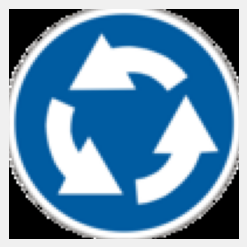

In [ ]:
img_path = '40.png'
data =[]
image = cv2.imread(img_path)[...,::-1]

plt.imshow(image)
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.show()

image_fromarray = Image.fromarray(image, 'RGB')
resize_image = image_fromarray.resize((image_height, image_width))
data.append(np.array(resize_image))
x = np.array(data)
# Нормалізація
x = x/255

def predict(model):
  pred = np.argmax(model.predict(x), axis=-1)
  print(pred)
  print("Its a", classes[pred[0]])

Нейронна мережа із 13ма шарами:

In [ ]:
predict(model)

1/1 [==============================] - 0s 19ms/step
[40]
Its a Roundabout mandatory


Нейронна мережа із VGG19:

In [ ]:
predict(modelVGG19)

1/1 [==============================] - 0s 21ms/step
[40]
Its a Roundabout mandatory


Нейронна мережа із архітектурою LeNet-5:

In [ ]:
predict(modelLN5)

1/1 [==============================] - 0s 20ms/step
[7]
Its a Speed limit (100km/h)
